#**Kannada MNIST**

* <h3> Benedikt Mueller 201973306

###1. **Introduction**

Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script.

####1.1 Problem framing
To starting any machine learning task, it is important to think carefully about the problem you are working on and take time to understand the data. The dataset used is a collection of hand-written digits written in the Kannada script and the training set contains 786 columns (features) and 60,000 records (images). The columns contain an id field, a label field and pixel000 to pixel783 fields. The label field is an integer number from 0 to 9 representing the hand-written digit. The 784 pixel-columns are values of the image metrics represented by the gray scale of each pixel. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). 

 

The main objective is to build a classification model that predicts the hand-written digits. A typical performance measure for classification problems is Classification Accuracy therefore it will be used to evaluate the success of our model against the test data provided as this will identify the fraction of predictions our model got right. 

####1.2 Packages
During the modelling process, the following (main) libraries were used: 

*   Pandas: Provides a DataFrame structure to store data in memory and work with it easily and efficiently. 
*   NumPy: Provides a fast numerical array structure and helper functions. 
*   Matplotlib, Seaborn: Data visualisation libraries in Python.
*   Keras (with tensorflow backend): High-level library to help develop and train Neural Networks models without ease.
*   Keras-tuner: Hyperparameter GridSearch for Keras (not part of the Keras repository). 
*   Scikit-learn: The essential Machine Learning package in Python. 

In [ ]:
from IPython.utils import io
from IPython.display import display
with io.capture_output() as captured: #surpresses any output
  import pandas as pd
  import numpy as np
  import seaborn as sns
  import datetime,time, os
  import matplotlib.pyplot as plt
  sns.set_style({'axes.grid' : False})
  %matplotlib inline
  %tensorflow_version 2.x
  import tensorflow as tf
  from tensorflow import keras
  #from __future__ import print_function
  from tensorflow.keras import backend as K
  from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,BatchNormalization
  from tensorflow.keras.layers import Dense, Dropout,SpatialDropout2D, Flatten, Activation
  from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
  from tensorflow.keras.callbacks import ReduceLROnPlateau, History
  from tensorflow.keras.models import Sequential,load_model
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  !pip install keras-tuner #==1.0.0
  from kerastuner.tuners import RandomSearch
  from kerastuner.engine.hyperparameters import HyperParameters
  %load_ext tensorboard
print("Loading done!", "\nTensorflow Version: ", tf.__version__)

Loading done! 
Tensorflow Version:  2.2.0-rc2


###2. Data preparation
####2.1 Load data

The data was loaded with Kaggle´s API.

In [ ]:
#load kaggle tok en
from google.colab import files
uploaded = files.upload()

In [ ]:
#create instance 
!ls -lha kaggle.json
#!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
with io.capture_output() as captured:
  # load training & test datasets
  !kaggle competitions download -c cs98x-kannada-mnist
print("Download done!")

Download done!


####2.2 Data Exploration

Once the datasets have been loaded it is important to explore them in more detail. The training data had 60,000 rows and 786 columns whereas the competition data had 10,000 rows and 785 columns as the label field has been removed. The visualised 10 classes show what each hand-written image looked like for numbers 0 to 9. Kannada digits 0 & 1 are very similar and so are digits 6 & 9 and this is expected to be sources of potential misclassification. 

In [ ]:
# load training & competition datasets
train = pd.read_csv("/content/training.csv.zip")
unlabelled_dataset = pd.read_csv("/content/test.csv.zip")

img_size =  28 # input image dimensions
num_classes = 10 # no of classes 

print("NaNs in training set: ", sum(np.array(train.isna().sum())))
print("Training data rows,columns: ", train.shape,"\nCompetition data: ", unlabelled_dataset.shape )
print("Max value: ", np.amax(np.array(train.iloc[:,2:])))

NaNs in training set:  0
Training data rows,columns:  (60000, 786) 
Competition data:  (10000, 785)
Max value:  255


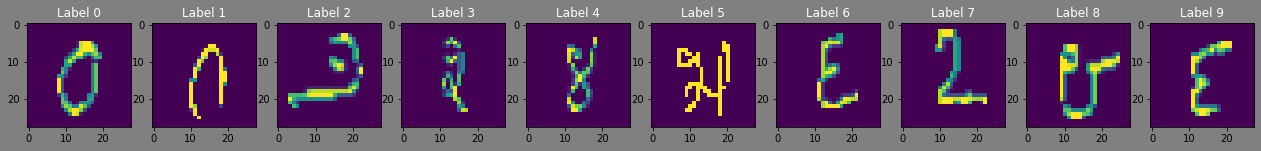

In [ ]:
# examples of the different classes
pic_train = np.array(train.iloc[:,2:].loc[train['label'].duplicated(keep='first')==False])
pic_label = np.array(train.iloc[:,1].loc[train['label'].duplicated(keep='first')==False])
fig, ax = plt.subplots(1, 10,figsize=(22,16),facecolor="grey",sharex=False,sharey=False)
for i in range(num_classes):  
  ax[i].imshow(pic_train[i].reshape((28,28)),interpolation=None)
  ax[i].set_title(f"Label {pic_label[i]}",color="white")
plt.show()

#### 2.3 Data Preparation
To evaluate the model, it was split into training, testing and validation set using roughly 80% training set and 10% validation set (and testing). Large integer values can disrupt or slow down the learning process. As such, it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1 by dividing by max-value.

The plots below show that the data sets are uniformly distributed (if stratify is enabled). It is to be assumed that the competition dataset has also the same uniform distribution between all labels. 

In [ ]:
from sklearn.model_selection import train_test_split
set_seed = 454332 #for reproducability set seed
x_train_full, x_test, y_train_org_full, y_test_org = train_test_split( train.iloc[:,2:],train.iloc[:,1], train_size=0.9,stratify=train.iloc[:,1], random_state=set_seed) # create test instances
x_train, x_val, y_train_org, y_val_org = train_test_split( x_train_full,y_train_org_full, train_size=0.9,stratify=y_train_org_full, random_state=set_seed) # create val instances

In [ ]:
x_train = np.array(x_train).reshape(-1,img_size,img_size,1).astype('float32')
x_test = np.array(x_test).reshape(-1,img_size,img_size,1).astype('float32')
x_val = np.array(x_val).reshape(-1,img_size,img_size,1).astype('float32')

# for Selu - Standardization
#from sklearn import preprocessing
#x_train = preprocessing.scale(x_train)
#x_test = preprocessing.scale(x_test)
#x_val = preprocessing.scale(x_val)

# Normalization - /255 for the sake of simplicity (max value) 
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_org, num_classes)
y_test = keras.utils.to_categorical(y_test_org, num_classes)
y_val = keras.utils.to_categorical(y_val_org, num_classes)

# input shape
input_shape = x_train.shape[1:]

print("Shapes after reshaping: ",x_train.shape,x_test.shape,x_val.shape)

Shapes after reshaping:  (48600, 28, 28, 1) (6000, 28, 28, 1) (5400, 28, 28, 1)


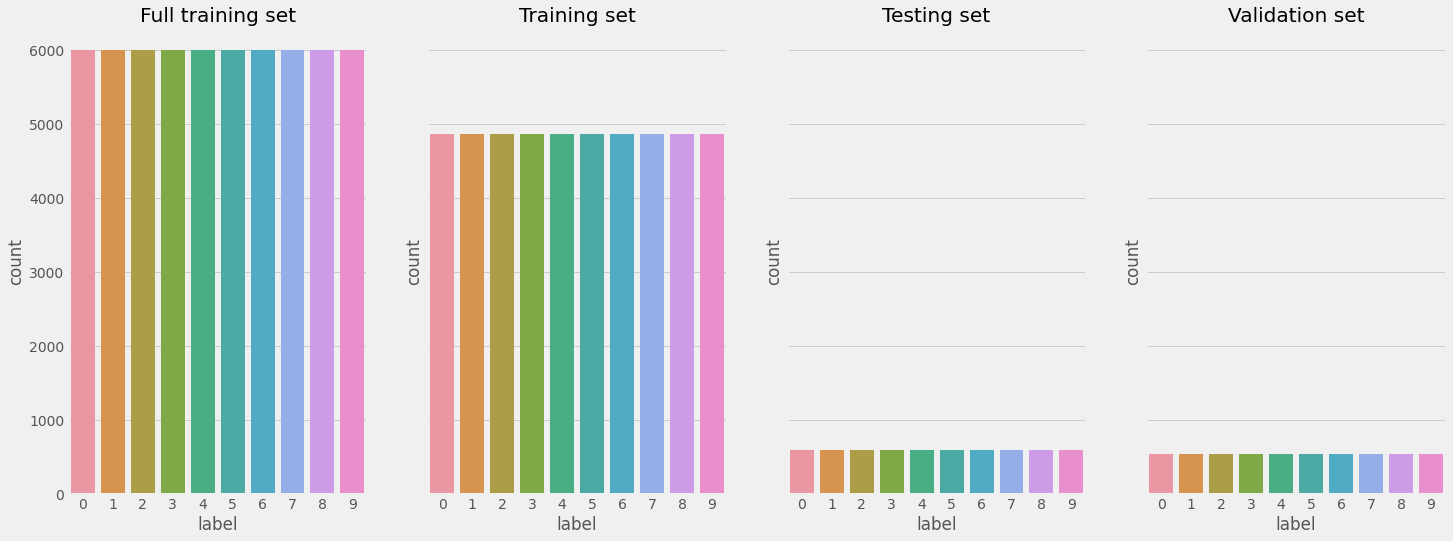

In [ ]:
# plot different distributions - if stratify split, then all balanced
fig, ax = plt.subplots(1, 4,figsize=(22,8), sharex='col', sharey='row')
sns.countplot(train.iloc[:,1],ax=ax[0])
ax[0].set_title('Full training set')
sns.countplot(y_train_org,ax=ax[1])
ax[1].set_title('Training set')
sns.countplot(y_test_org,ax=ax[2])
ax[2].set_title('Testing set')
sns.countplot(y_val_org,ax=ax[3])
ax[3].set_title('Validation set')
plt.show()

###3. Convolutional Neural Networks (CNN)
CNNs are the go-to instrument for top notch and fast image classifications, setting new benchmarks on MNIST and other related datasets. The network´s convolution-layer allows an image to be represented as a 2d-object from the beginning. By screening different parts of an images, the convolutional-layers can extract hidden lower and higher-level features and aligns CNNs with real-work structures of images. The sparse connection of such convolution along with the shared parameters between different layers, reduce the number of parameters and ergo the model´s runtime. The structure is usually followed by a pooling-layer, which acts as a kind of subsampling method to reduce computational effort and overfitting. After the described procedure, the created matrix must be passed through a flatten-layer. 



#### 3.1 Approach
After testing and evaluating non-CNN kernel architecture, the first breakthrough in terms of test accuracy was achieved with a simple CCN structure. This structure more or less resulted in trial and error of a bunch of different, "simple" CCNs - assisted by class materials and the book (Hands on Machine Learning - by Aurélien Géron). To explore a wide range of those different architectures and to validate the final choice, this approach tries to follow some basic deliberations:

* Number of consecutive convolutional layer, 
* Number of convolutional *meta* layers (depth of net),
* Tuning of Hyperparameters: feature maps (filters), sliding window (kernel_size), strides, etc.,
* Evaluation of dropouts and regularization techniques and other helpers.

The procedure starts with this basic structure:

Layer | Specifications | Translation
--- | --- | ---
Input | size: 28x28 | -
Conv2D | maps: 32, filter: 3, stride: 1 | Conv_32,3,1
Activation | relu | Act_relu
MaxPooling | pool size: 2 | MaxPool_2
Flatten | 6272 | Flat
Dense  | size: 128, activation: relu | Dense_64
Out  | size: 10, activation: softmax | -


The last layer ("softmax") and the essential compile setup are the most used in classification tasks as presented here. Regarding the optimizer, though, there has aroused some discussions recently, claiming that SGD optimisation can still outperform adaptive techniques ([link](https://arxiv.org/abs/1705.08292)). It will be tested later, whether the SGD also suits the model developed in the following.  

#### 3.2 Pre-setups
To start the testing sequence, 3 helpers were implemented beforehand:


*   Early stopping: interrupting execution, if no further progress is made (after defined number of epochs),
*   Learning Rate Annealer: lowering the LR, if model get stuck,
*   Image Generator: Generating artificial (new) pictures based on rotating, zooming and shifting the originals.


Rather than monitoring the validation accuracy, both callbacks concentrate on the validation loss. It was examined, that this was beneficial for the model´s generalisation power. Therefore, the following process weights validation (and testing) loss additionally to accuracy to justify the decisions-making. 
Lastly, after applying the image augmentation (imagegen), the base model increased its accuracy by 1.5% on average (compared to the model without). The chosen parameters were set to relatively low values due to the mentioned similarities between some digits (flipping and mirroring were avoided for the same reason). This should prevent ambiguous depictions. 

In [ ]:
# create early stopping and learning rate callback and image generator instance
earlystopping = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_loss')
annealer = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=0, 
                                            factor=0.25,min_lr=0.0001)
imagegen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

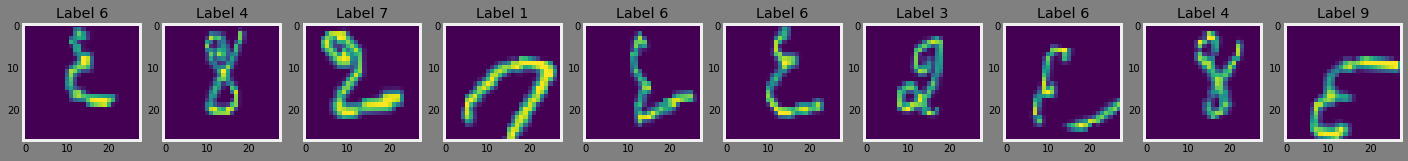

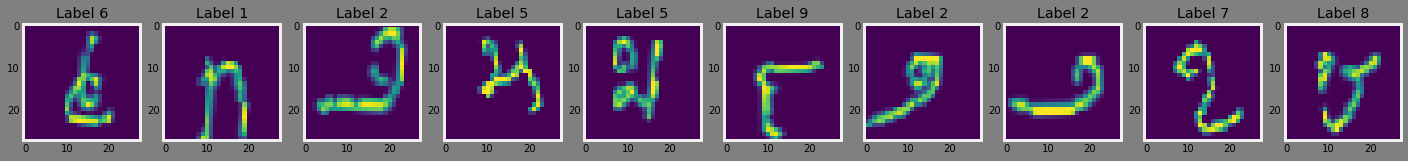

In [ ]:
# example of image gen pictures
pic_image = imagegen.flow(x_test, y_test_org, batch_size=10,shuffle=False)
for i in range(2):
  x_batch, y_batch = next(pic_image)
  fig, ax = plt.subplots(1, 10,figsize=(22,16),facecolor="grey",sharex=False,sharey=False)
  for i in range(10):  
    ax[i].imshow(x_batch[i].reshape((28,28)),interpolation=None)
    ax[i].set_title(f"Label {y_batch[i]}",color="white")
  plt.show()

The following functions help to evaluate all further setups (except tuning). It is therefore not necessary to create the model´s pre-setups (applying img gen), training, valuation and testing for every approach anew. It was decided to run 15 epochs per model and test them on a batch of 64. The steps-per-epochs was initially set to length-of-data divided by the batch-size. 

In [ ]:
# function of evaluation function - calls the model to train, test and evaluate. Print end results and stores history
def model_evaluation(eval_model,num_models,batch_size,epochs,show_summary):

    # generate pics
    train_gen = imagegen.flow(x_train, y_train, batch_size=batch_size)
    val_gen = imagegen.flow(x_val, y_val, batch_size=batch_size)

    model = eval_model #re-define model -> get model from defined model outside of the function
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) 
    if show_summary == True:
      model.summary()
    # hand over newly generated training/validation dataset
    history = model.fit_generator(train_gen, epochs=epochs,verbose=0,
              steps_per_epoch = x_train.shape[0]//batch_size,
              validation_data=val_gen, validation_steps = x_val.shape[0]//batch_size,
              callbacks=[annealer,earlystopping])
    eval_hist = model.evaluate(x_test, y_test, verbose=0)

    # make results availible outside of function
    model_evaluation.tested_model = model 
    model_evaluation.model_history = history

    # print the final results of each run 
    print("CNN {0:d}: Epochs={1:d} | Train accuracy={2:.5f}, Train loss={5:.5f} || Validation accuracy={3:.5f}, Validation loss={6:.5f} || \
    Evaluation accuracy={4:.5f}, Evaluation loss={7:.5f}".format(
    num_models+1,epochs,max(history.history['accuracy']),max(history.history['val_accuracy']),eval_hist[1],\
    min(history.history['loss']),min(history.history['val_loss']),eval_hist[0]))

# function of creating a plot to visualise different setup-performance histories
def create_history_plot(hist_data,num_models,figsize):
    for i in range(num_models):
      try: # see if data is stored in a list of dicts
          pic_results = pd.DataFrame(hist_data.history) 
      except:
          pic_results = pd.DataFrame(hist_data[i].history)
      plt.style.use('ggplot')
      fig, ax = plt.subplots(1, 2,figsize=figsize, sharex=False, sharey=False)
      sns.lineplot(data=pic_results[["loss","val_loss"]],lw=1,ax= ax[0])
      sns.lineplot(data=pic_results[["accuracy","val_accuracy"]],lw=1,ax= ax[1])
      start, end = ax[0].get_xlim()
      ax[0].xaxis.set_ticks(np.arange(0, end, 2))
      ax[1].xaxis.set_ticks(np.arange(0, end, 2))
      ax[0].set_xlabel("Epoch",fontsize=10)
      plt.suptitle("CNN "+str(i+1),fontsize=14,color="grey")
      plt.show()

####3.3 Number of Convolution structures
To test the first different setups, the pre-defined functions are called into action by handing over the model and looping through the different architetures. The following test will evaluate whether a deeper CNN can increase the kaggle score (the maps commonly increase in size after each pooling):


1.   Conv_32,3,1,relu - MaxPool_2 - Flat - Dense_64
2.   Conv_32,3,1,relu - MaxPool_2 - Conv_48,3,1,relu - MaxPool_2 - Flat - Dense_64
3.   Conv_32,3,1,relu - MaxPool_2 - Conv_48,3,1,relu - MaxPool_2 - Conv_64,3,1,relu - MaxPool_2 - Flat - Dense_64

It does not make sense to add a fourth Conv-MaxPool-layer (shrinks the image size too much). There was also no difference between applying the Activation or the Pooling first, so the more convenient appraoch was chosen. 


In [ ]:
# hand over i as indicator for model, num_models for creating list of models
def second_model(i,num_models):
    model = [0]*num_models # create list to initialise model anew, might be unnecessary but afraid of interactions between different setups
    model[i] = Sequential()
    model[i].add(Conv2D(filters = 32,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
    model[i].add(MaxPooling2D())

    if i > 0: # CCN 2
      model[i].add(Conv2D(filters = 48,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
    
    if i > 1: # CCN 3
      model[i].add(Conv2D(filters = 64,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())

    model[i].add(Flatten())
    model[i].add(Dense(64, activation='relu'))
    model[i].add(Dense(10,activation="softmax"))

    return model[i]

In [ ]:
second_model(2,3).summary() #example of fist model architecture

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 48)        13872     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 64)          27712     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 576)             

CNN 1: Epochs=15 | Train accuracy=0.98414, Train loss=0.05045 || Validation accuracy=0.98549, Validation loss=0.04738 ||     Evaluation accuracy=0.98833, Evaluation loss=0.03689
CNN 2: Epochs=15 | Train accuracy=0.98960, Train loss=0.03276 || Validation accuracy=0.99051, Validation loss=0.03119 ||     Evaluation accuracy=0.99283, Evaluation loss=0.02215
CNN 3: Epochs=15 | Train accuracy=0.99180, Train loss=0.02578 || Validation accuracy=0.99237, Validation loss=0.02568 ||     Evaluation accuracy=0.99217, Evaluation loss=0.03272


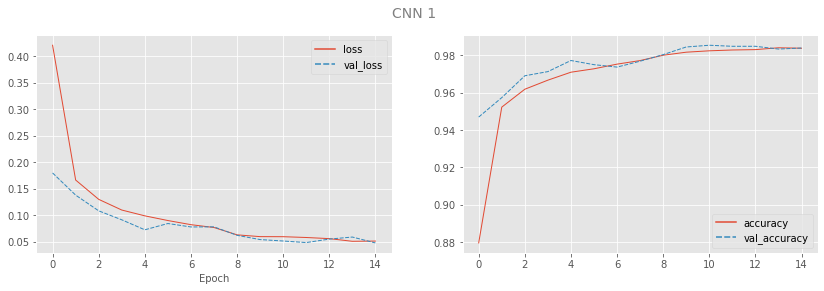

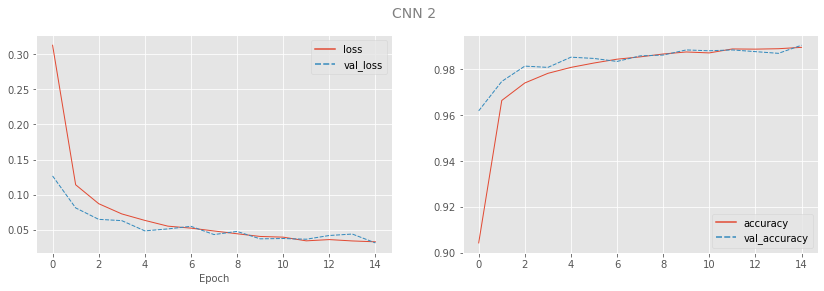

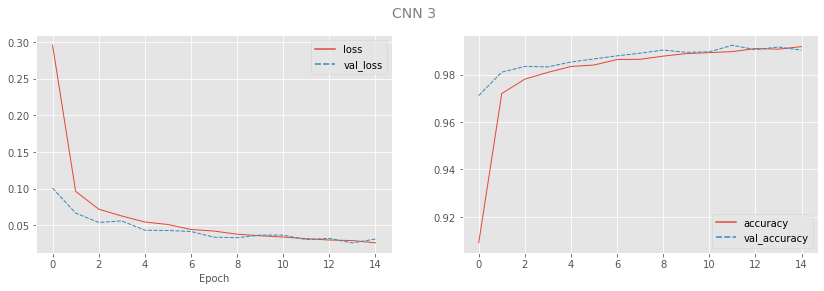

In [ ]:
# Define model eval_model to test, epochs, batchsize, num_models
num_models = 3 
model_tested = [0]*num_models # create list to store tested model
model_history = [0]*num_models # store results
for i in range(num_models):
    model_evaluation(eval_model=second_model(i,num_models), # define eval_model
                    batch_size=64, epochs=15,
                    num_models=i,show_summary = False)
    model_tested[i] = model_evaluation.tested_model
    model_history[i] =  model_evaluation.model_history
#model_tested[0].summary()
create_history_plot(model_history,num_models,figsize=(14,4)) # Create plots

As the plot suggest, the 3 conv networks still seem to learn after the 15th epoch. CNN 1 and 2 appear to level off after the 13th epoch. 
The evaluation shows that the higher number of convolutional layers could slightly enhance the validation prediction, and significantly lower its loss (same for evaluation). The best model is CNN 3 with the best scores overall. This was also validated by the best kaggle score of 97.1%. 

It is noteworthy that there is a discrepancy of 2-3% between evaluation accuracy and kaggle score. This can be a hint for lack of generalisation power, yet, lowering the loss seems to be a better predictor - as already mentioned. 

####3.4 Feature map size
Since the feature map can have a significant influence of the model´s learning ability and runtime, it is crucial to evaluate different values. Generally, the maps follow an ascending order:


1.   Conv_16,3,1,relu - MaxPool_2 - Conv_32,3,1,relu - MaxPool_2 - Conv_48,3,1,relu - MaxPool_2 - Flat - Dense_64
2.   Conv_48,3,1,relu - MaxPool_2 - Conv_64,3,1,relu - MaxPool_2 - Conv_80,3,1,relu - MaxPool_2 - Flat - Dense_64
3.   Conv_32,3,1,relu - MaxPool_2 - Conv_64,3,1,relu - MaxPool_2 - Conv_96,3,1,relu - MaxPool_2 - Flat - Dense_64
4.   Conv_64,3,1,relu - MaxPool_2 - Conv_128,3,1,relu - MaxPool_2 - Conv_192,3,1,relu - MaxPool_2 - Flat - Dense_64
5.   Conv_96,3,1,relu - MaxPool_2 - Conv_128,3,1,relu - MaxPool_2 - Conv_192,3,1,relu - MaxPool_2 - Flat - Dense_64
6.   Conv_64,3,1,relu - MaxPool_2 - Conv_96,3,1,relu - MaxPool_2 - Conv_256,3,1,relu - MaxPool_2 - Flat - Dense_64





In [ ]:
def third_model(i,num_models):  
    model = [0]*num_models 
    model[i] = Sequential()

    if i == 0: # CNN 1
      model[i].add(Conv2D(filters = 16,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 32,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 48,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())

    if i == 1: # CNN 2
      model[i].add(Conv2D(filters = 48,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 64,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 80,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
    
    if i == 2: # CNN 3
      model[i].add(Conv2D(filters = 32,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 64,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 96,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())

    if i == 3: # CNN 4
      model[i].add(Conv2D(filters = 64,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 128,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 192,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())

    if i == 4: # CNN 5
      model[i].add(Conv2D(filters = 96,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 128,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 192,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
    
    if i == 5: # CNN 6
      model[i].add(Conv2D(filters = 64,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 96,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())
      model[i].add(Conv2D(filters = 256,kernel_size=3, padding = "same", activation="relu"))
      model[i].add(MaxPooling2D())

    model[i].add(Flatten())
    model[i].add(Dense(64, activation='relu'))
    model[i].add(Dense(10,activation="softmax"))

    return model[i]

CNN 1: Epochs=15 | Train accuracy=0.99215, Train loss=0.02346 || Validation accuracy=0.99349, Validation loss=0.02482 ||     Evaluation accuracy=0.99233, Evaluation loss=0.02178
CNN 2: Epochs=15 | Train accuracy=0.99481, Train loss=0.01671 || Validation accuracy=0.99293, Validation loss=0.02362 ||     Evaluation accuracy=0.99483, Evaluation loss=0.02058
CNN 3: Epochs=15 | Train accuracy=0.99207, Train loss=0.02466 || Validation accuracy=0.99275, Validation loss=0.02607 ||     Evaluation accuracy=0.99033, Evaluation loss=0.03345
CNN 4: Epochs=15 | Train accuracy=0.99642, Train loss=0.01090 || Validation accuracy=0.99368, Validation loss=0.01991 ||     Evaluation accuracy=0.99500, Evaluation loss=0.01605
CNN 5: Epochs=15 | Train accuracy=0.99330, Train loss=0.02115 || Validation accuracy=0.99368, Validation loss=0.02243 ||     Evaluation accuracy=0.99350, Evaluation loss=0.02429
CNN 6: Epochs=15 | Train accuracy=0.99326, Train loss=0.02019 || Validation accuracy=0.99312, Validation loss=

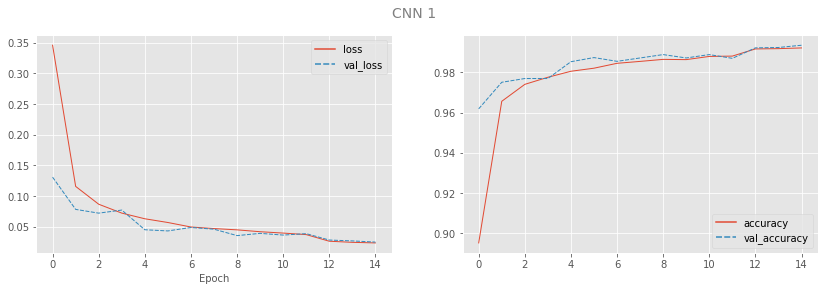

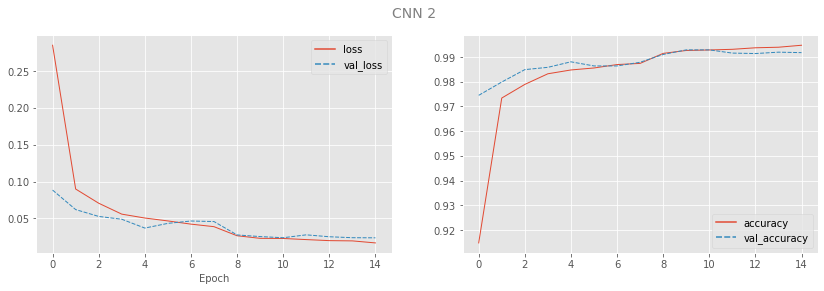

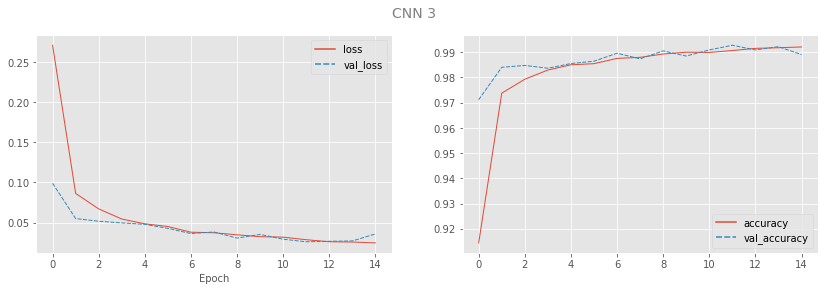

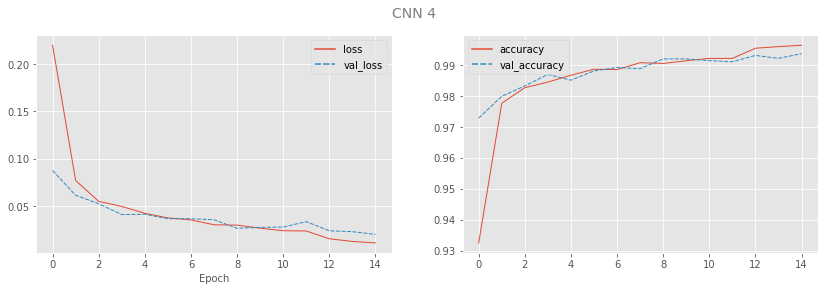

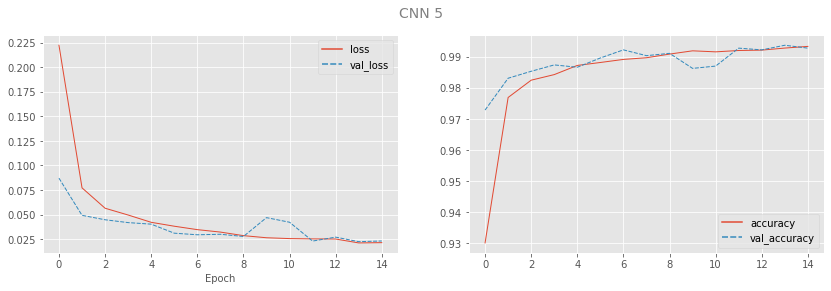

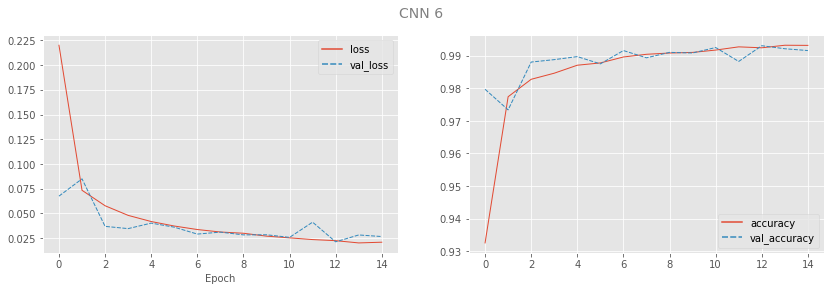

In [ ]:
num_models = 6 # num of tested models

model_tested = [0]*num_models
model_history = [0]*num_models
for i in range(num_models):
    model_evaluation(eval_model=third_model(i,num_models), # define eval_model
                    batch_size=64, epochs=15,
                    num_models=i,show_summary = False)
    model_tested[i] = model_evaluation.tested_model
    model_history[i] =  model_evaluation.model_history
create_history_plot(model_history,num_models,figsize=(14,4)) # Create plots

CNN 4 achieved the lowest validation loss among all models. However, all models could lower the initial loss of CNN 3 and they nearly achieved the same validation accuracies. The decisive factor to proceed with CNN 4 was the promising overall picture of a 2 times lower training loss and a low evaluation loss. By tweaking the right parameters, the model might still be able to improve (kaggle scores: CCN 4: 97.9%, also submitted: CNN 5, 6: 97.1%, CNN 2: 96.666%).

####3.5 Consecutive convolutional layers
The last trial will evaluate whether to set two Convolution layers before a MaxPooling among the deeper layers:


1.   Conv_128,3,1,relu - Conv_128,3,1,relu - MaxPool_2 - Conv_192,3,1,relu - MaxPool_2 - Flat - Dense_64
2.   Conv_128,3,1,relu -  MaxPool_2 - Conv_192,3,1,relu - Conv_192,3,1,relu - MaxPool_2 - Flat - Dense_64
3.   Conv_128,3,1,relu - Conv_128,3,1,relu - MaxPool_2 - Conv_192,3,1,relu - Conv_192,3,1,relu - MaxPool_2 - Flat - Dense_64



In [ ]:
def fourth_model(i,num_models): 
    model = [0]*num_models  
    model[i] = Sequential()
    model[i].add(Conv2D(filters = 64,kernel_size=3, padding = "same", activation="relu", input_shape = input_shape))
    
    model[i].add(MaxPooling2D())
    
    model[i].add(Conv2D(filters = 128,kernel_size=3, padding = "same", activation="relu"))
    
    if (i == 0 or i == 2): # i=0 -> CNN 1
      model[i].add(Conv2D(filters = 128,kernel_size=3, padding = "same", activation="relu"))
    model[i].add(MaxPooling2D())
    
    model[i].add(Conv2D(filters = 192,kernel_size=3, padding = "same", activation="relu"))
    if (i == 1 or i == 2): # i=1 -> CNN 2
      model[i].add(Conv2D(filters = 192,kernel_size=3, padding = "same", activation="relu"))
    model[i].add(MaxPooling2D())

    model[i].add(Flatten())
    model[i].add(Dense(64, activation='relu'))
    model[i].add(Dense(10,activation="softmax"))

    return model[i]

CNN 1: Epochs=15 | Train accuracy=0.99714, Train loss=0.00806 || Validation accuracy=0.99591, Validation loss=0.01626 ||     Evaluation accuracy=0.99483, Evaluation loss=0.01416
CNN 2: Epochs=15 | Train accuracy=0.99749, Train loss=0.00769 || Validation accuracy=0.99591, Validation loss=0.01532 ||     Evaluation accuracy=0.99617, Evaluation loss=0.01192
CNN 3: Epochs=15 | Train accuracy=0.99730, Train loss=0.00847 || Validation accuracy=0.99572, Validation loss=0.01794 ||     Evaluation accuracy=0.99650, Evaluation loss=0.01110


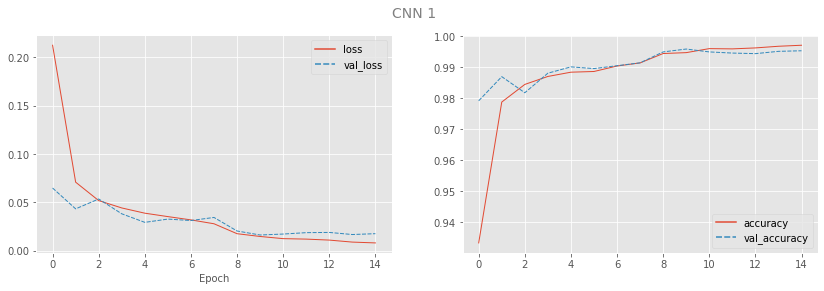

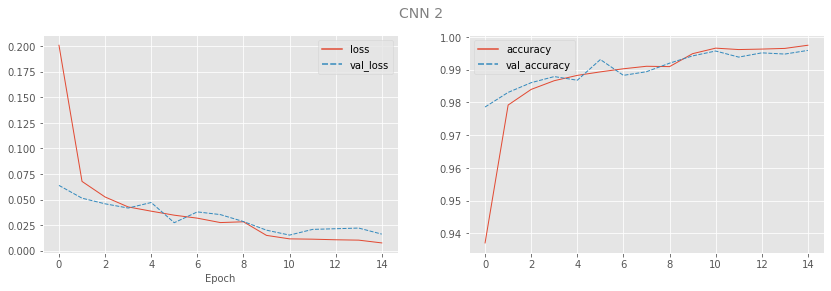

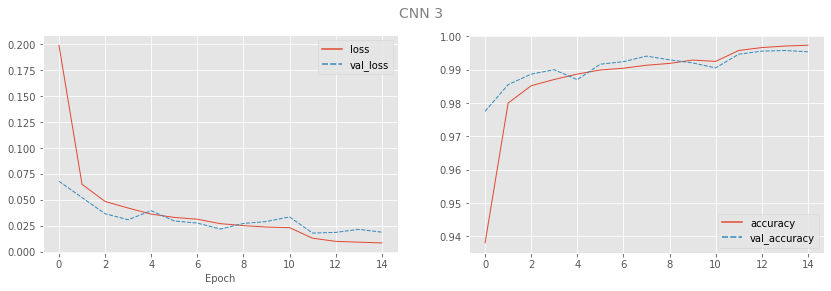

In [ ]:
num_models = 3

model_tested = [0]*num_models 
model_history = [0]*num_models 
for i in range(num_models):
    model_evaluation(eval_model=fourth_model(i,num_models), # define eval_model
                    batch_size=64, epochs=15,
                    num_models=i,show_summary = False)
    model_tested[i] = model_evaluation.tested_model
    model_history[i] =  model_evaluation.model_history
create_history_plot(model_history,num_models,figsize=(14,4)) # Create plots

Adding just one additonal layer seems to be the better fit than applying both at the same time. All models could again lower the validation error, enhancing the kaggle score. CNN 2 and 3 break the 98%-barrier for the first time, with CNN 2 obtaining 98.1%. This model was chosen for the final hyperparamter test and hopefully, the tuner could squeeze out the last, missing decimals. 

####3.6 Hyperparameters and overfitting preventions
With the aid of Keras-tuner it is possible to test a variety of possible variations to finalise the model. The following parameters are evaluated:


*   BatchNormalization and Dropouts (with different rates) to challenge the mentioned overfitting issues,
*   Average vs. MaxPooling,
*   Different batch sizes, kernel sizes and initializers,
*   Different Dense layer sizes,
*   Different starting learning rates,
*   Different optimizers.


Note that the general idea of Convolutional-layers is to exploit pixels within a spatial connection to extract the right features to feed into the Dense-layer, ergo it is adivsable to use SpatialDropouts. The batch-size is held "relatively" low, since large batches prone to overfit ([post](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e)).

In [ ]:
# model config for tuner
def tune_model(hp):  
  model = Sequential()
  
  kernel_setup_1 = hp.Choice('kernel_size1',values=[3,5,7])#,11]) # too large
  kernel_setup_2 = hp.Choice('kernel_size2',values=[3,5])#,7])
  kernel_setup_3 = hp.Choice('kernel_size3',values=[3,5])
  kernel_init = hp.Choice('kernel_init',values=["glorot_uniform"])#,"he_normal"]) # never popped up among the best
  activ_setup = hp.Choice('activation', values=["relu"])#,"tanh"]) #tanh sucks
  batchnorm_setup = hp.Choice('batchn_norm', values=["on"])#,"off"])
  pooling_setup = hp.Choice('pooling', values=["avg","max"])
  compile_setup = hp.Choice('optimizer', values=["adam"]) #,"sgd","nadam"]) #it was adam all along..

  model.add(Conv2D(filters = 64,kernel_size=kernel_setup_1, padding = "same", activation=activ_setup, input_shape=input_shape,kernel_initializer=kernel_init))
  
  if batchnorm_setup == "on":
    model.add(BatchNormalization()) 
  if pooling_setup == "max":
    model.add(MaxPooling2D())
  else:
    model.add(AveragePooling2D())

  #model.add(Conv2D(filters = 128,kernel_size=kernel_setup_2, padding = "same", activation=activ_setup,kernel_initializer=kernel_init))
  model.add(Conv2D(filters = 128,kernel_size=kernel_setup_2, padding = "same", activation=activ_setup,kernel_initializer=kernel_init))
  model.add(SpatialDropout2D(hp.Choice('spatial_drpout1', values=[0.0,0.1,0.2])))
  if batchnorm_setup == "on":
    model.add(BatchNormalization()) 
  if pooling_setup == "max":
    model.add(MaxPooling2D())
  else:
    model.add(AveragePooling2D())

  model.add(Conv2D(filters = 192,kernel_size=kernel_setup_3, padding = "same", activation=activ_setup,kernel_initializer=kernel_init))
  model.add(Conv2D(filters = 192,kernel_size=kernel_setup_3, padding = "same", activation=activ_setup,kernel_initializer=kernel_init))
  model.add(SpatialDropout2D(hp.Choice('spatial_drpout2', values=[0.0,0.1,0.2])))
  if batchnorm_setup == "on":
    model.add(BatchNormalization()) 
  if pooling_setup == "max":
    model.add(MaxPooling2D())
  else:
    model.add(AveragePooling2D())

  model.add(Flatten())
  model.add(Dense(hp.Int('dense_layer', min_value=64,max_value=512,step=64), activation=activ_setup))
  model.add(Dropout(hp.Choice('drpout3', values=[0.0,0.25,0.5])))
  model.add(Dense(10,activation="softmax"))
  
  if compile_setup == "sgd":
    optiM = keras.optimizers.SGD(momentum=0.9, nesterov=True)
  if compile_setup == "adam":
    optiM = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, amsgrad=False) #higher lr sucks
  if compile_setup == "nadam": 
    optiM = keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999)

  model.compile(optimizer=optiM,loss="categorical_crossentropy", metrics=["accuracy"]) 
  
  return model

To make the batch hyperparameter work, it must be implemented in the tuner class. As before, the tuner´s metrics will be set to validation loss. For the first run, 200 combinations were tested (roughly 0.1% of all models possible). This run revealed that some parameters rather increased the validation loss and were dismissed (e.g. large kernel_size, sgd optimizer). This shrinks the searchspace to "just" 50 thousand possible models (25% of the size from the first approach). 

In [ ]:
# from github keras-tuner repository
import kerastuner.tuners
class CostumTuner(kerastuner.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=32, max_value=256, step=32)
    super(CostumTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
logdir = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir_tensorboard = os.path.join("logs", logdir)
MOD_NAME = "CCN-final.h5"
print(logdir)
tensorboard = TensorBoard(log_dir=logdir_tensorboard) # in case of visualisation needs
checkpoint = ModelCheckpoint(MOD_NAME, save_best_only=True) # save best model if runtime error occurs
#same as before, but it sometimes raised an error if not stated anew, so..
earlystopping2 = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_loss')
annealer2 = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=0, 
                                            factor=0.5,min_lr=0.0001)
epochs = 30 # higher epochs just in case there is a model still learning...
tuner_history = History()
tuner = CostumTuner(
        tune_model,
        objective='val_loss',
        max_trials=100,  # num of different models to test
        executions_per_trial=1,  # num of exc. per model
        directory=logdir)

history = tuner.search(x_train,y_train,
             verbose=0, 
             epochs=epochs,
             callbacks=[checkpoint,earlystopping2,annealer2],  
             validation_data=(x_val,y_val))

In [ ]:
##%tensorboard --logdir_tensorboard logs
eval_hist = tuner.get_best_models()[0].evaluate(x_test, y_test, verbose=0)
print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 128)         0

{'kernel_size1': 5, 'kernel_size2': 5, 'kernel_size3': 3, 'kernel_init': 'glorot_uniform', 'activation': 'relu', 'batchn_norm': 'on', 'pooling': 'avg', 'spatial_drpout1': 0.2, 'spatial_drpout2': 0.1, 'dense_layer': 320, 'drpout3': 0.5, 'batch_size': 256}

The specification and architecture of the final model can be seen above.
This model generated the following losses and scores: 

Metrics | Train | Validation | Evaluation | Kaggle
--- | --- | --- | --- | ---
accuracy | 0.99787 | 0.99721 | 0.9955 | 0.983
loss | 0.00691 | 0.01065 | 0.01449 | -

The 10 hours of hyperparameter tuning were not for nothing: The final kaggle upload got an additional lift to rank among the Top5. However, it did not entirely solve the overfitting, lack of generalisation problem. 

In [ ]:
# redo model due to loss of tuner history due to system crash
def final_model(i,num_models): 
    model = [0]*num_models  
    model[i] = Sequential()
    model[i].add(Conv2D(filters = 64,kernel_size=5, padding = "same", activation="relu", input_shape = input_shape))
    model[i].add(BatchNormalization()) 
    model[i].add(AveragePooling2D())
    
    model[i].add(Conv2D(filters = 128,kernel_size=5, padding = "same", activation="relu"))
    model[i].add(SpatialDropout2D(0.2))
    model[i].add(BatchNormalization()) 
    model[i].add(AveragePooling2D())
    
    model[i].add(Conv2D(filters = 192,kernel_size=3, padding = "same", activation="relu"))
    model[i].add(Conv2D(filters = 192,kernel_size=3, padding = "same", activation="relu"))
    model[i].add(SpatialDropout2D(0.1))
    model[i].add(BatchNormalization()) 
    model[i].add(AveragePooling2D())

    model[i].add(Flatten())
    model[i].add(Dense(320, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(10,activation="softmax"))

    return model[i]

In [ ]:
model_evaluation(eval_model=final_model(0,1), # define eval_model
                    batch_size=256, epochs=30,
                    num_models=0,show_summary = False)
model_tested = model_evaluation.tested_model
model_history =  model_evaluation.model_history

CNN 1: Epochs=30 | Train accuracy=0.99787, Train loss=0.00691 || Validation accuracy=0.99721, Validation loss=0.01065 ||     Evaluation accuracy=0.99550, Evaluation loss=0.01449


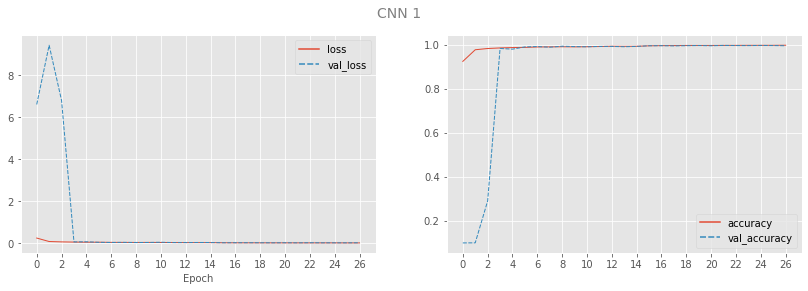

In [ ]:
create_history_plot(model_history,1,figsize=(14,4))

####3.7 Final model evaluation
With the aid of a Confusion Matrix it is easy to observe where the final model lacks in predictive power. 

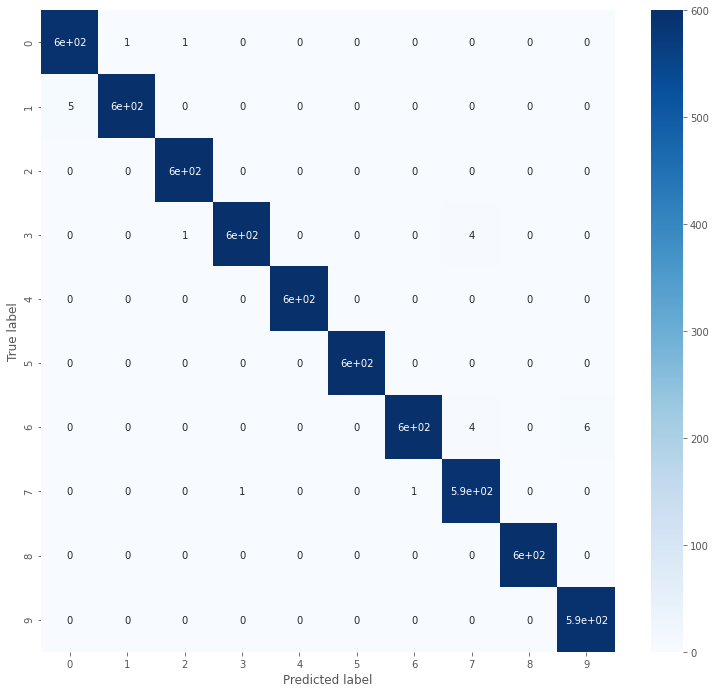

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred = model_tested.predict_classes(x_test)
y_true = np.argmax(y_test,axis=1)
conf_matr = confusion_matrix(y_true, test_pred)

fig = plt.figure(figsize=(10.5, 9.5))
sns.heatmap(conf_matr.T, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As predicted, the labels 9 and 6 (0 and 1, respectively) account for the highest single misclassification. Hoewever, this holds just for "one direction" (9 as 6 and 0 as 1, not vice versa). The model also seems to misclassify the label 7 and confuses it with either 6 and 3 in some cases. 

###4. Models tested

During the process of finding the best model, myriads of different models have been tested. The first test was with a fully connected network architecture, which performed alright, but the kaggle score could not been pushed above 95%. A CCN with Selu-activations was also evaluated. Unfortunately, it was abandoned before realizing, that it has been forgotton to apply the necessary scaling also on the competition dataset.  

####4.1 Final thoughts
To increase the testing procedure, the "base" model of each test could have been stored to pass the pre-trained structure to each different trial. Also, after finalising this project, a problem with the storage of the best models (Checkpoint) was recognized, but this would have caused just minor changes of the final result. The final model combines two desired aspirations: Giving the best kaggle-score while having a reasonable runtime.

###5. Submit competition predictions
The following bit of code will upload the predicted labels onto kaggle.

In [ ]:

x_competition = np.array(unlabelled_dataset.iloc[:,1:]).reshape(-1,img_size,img_size,1).astype('float32')
x_competition /= 255.0

###### ###### ###### ###### ###### ######
kagg_model =  model_tested
y_pred = kagg_model.predict_classes(x_competition) 
###### ###### ###### ###### ###### ######

In [ ]:
competition = unlabelled_dataset.copy()
competition["label"] = y_pred
prediction = competition[["id","label"]]

In [ ]:
prediction.to_csv("submission_prediction.csv", index=False)
#!kaggle competitions submit -c cs98x-kannada-mnist -f submission_prediction.csv -m "final-model"

100% 78.1k/78.1k [00:02<00:00, 34.5kB/s]
Successfully submitted to CS98X Kannada MNIST